# Step 1: Loading the necessary libraries

In [136]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

# Step 2: Loading & reading data from the database


In [150]:
conn = sqlite3.connect('classic.db')
order_details = pd.read_sql_query("SELECT * FROM orderdetails", conn)
products = pd.read_sql_query("SELECT * FROM products", conn)
conn.close()

# Step 3: Clean data

In [173]:
np.random.seed(42)
num_products = 10
num_samples = 100

In [174]:
data = {
    'productCode': np.random.choice([f'Product_{i}' for i in range(num_products)], num_samples),
    'quantityOrdered': np.random.randint(1, 100, num_samples)
}
demand_data = pd.DataFrame(data)

# Step 4: Aggregation & One-hot encoding

In [177]:
demand_data = demand_data.groupby('productCode').agg({'quantityOrdered': 'sum'}).reset_index()
demand_data['quantityOrdered'] += np.random.randint(1, 10, size=len(demand_data))
demand_data['productIndex'] = np.arange(len(demand_data))

# Step 5: Feature preparation for prediction

In [178]:
print("\nAggregated Demand DataFrame:")
print(demand_data_long)
print("Columns in the DataFrame:", demand_data_long.columns)
print("Rows in the DataFrame:", demand_data_long.head())


Aggregated Demand DataFrame:
   Total_Demand  Average_Demand  ...  productCode_quantityInStock  productCode_quantityOrdered
0     302461.89      100.955237  ...                        False                        False
1     163510.11       54.576138  ...                        False                        False
2      19266.00        6.430574  ...                        False                        False
3   30740017.00    10260.352804  ...                        False                        False
4     271945.42       90.769499  ...                        False                        False
5   15130027.00     5050.075768  ...                         True                        False
6     105516.00       35.218959  ...                        False                         True

[7 rows x 10 columns]
Columns in the DataFrame: Index(['Total_Demand', 'Average_Demand', 'Median_Demand', 'Order_Count',
       'productCode_buyPrice', 'productCode_orderLineNumber',
       'productCode_orderN

In [180]:
x = demand_data[['productIndex']]  # Features
y = demand_data['quantityOrdered']  # Target variable

In [181]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['productCode']),
        ('num', StandardScaler(), ['Total_Demand', 'Average_Demand', 'Median_Demand', 'Order_Count'])
    ])

In [182]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Step 6: Test Splitting

In [183]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Step 7: Prediction with Various Models

In [184]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
}

# Step 8: Model Evaluation

In [189]:
results = {}

for model_name, model in models.items():
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  # Mean Squared Error
  mse = mean_squared_error(y_test, y_pred)
  # Mean Absolute Error
  mae = mean_absolute_error(y_test, y_pred)
  # R-Squared
  r_squared = r2_score(y_test, y_pred)
  # Root Mean Squared Error
  rmse = np.sqrt(mse)

  # Print per model
  print(f"{model_name}:")
  print(f"  Mean Squared Error: {mse}")
  print(f"  Mean Absolute Error: {mae}")
  print(f"  Root Mean Squared Error: {rmse}")
  print(f"  R-Squared: {r_squared}")

  results[model_name] = {
      'Mean Squared Error': mse,
      'Mean Absolute Error': mae,
      'Root Mean Squared Error': rmse,
      'R-Squared': r_squared
  }

Linear Regression:
  Mean Squared Error: 1214.9920481569582
  Mean Absolute Error: 34.50000000000003
  Root Mean Squared Error: 34.85673605139985
  R-Squared: 0.928656828399057
Decision Tree:
  Mean Squared Error: 29776.5
  Mean Absolute Error: 157.5
  Root Mean Squared Error: 172.55868566954257
  R-Squared: -0.7484476152728234
Random Forest:
  Mean Squared Error: 9891.283449999997
  Mean Absolute Error: 70.51499999999999
  Root Mean Squared Error: 99.45493175303072
  R-Squared: 0.419193291349217
Gradient Boosting:
  Mean Squared Error: 29729.483243348746
  Mean Absolute Error: 157.37781551275566
  Root Mean Squared Error: 172.42239774272002
  R-Squared: -0.745686836267744


# Step 9: Visualization

In [190]:
results_df = pd.DataFrame(results).T
print(results_df)

                   Mean Squared Error  Mean Absolute Error  Root Mean Squared Error  R-Squared
Linear Regression         1214.992048            34.500000                34.856736   0.928657
Decision Tree            29776.500000           157.500000               172.558686  -0.748448
Random Forest             9891.283450            70.515000                99.454932   0.419193
Gradient Boosting        29729.483243           157.377816               172.422398  -0.745687


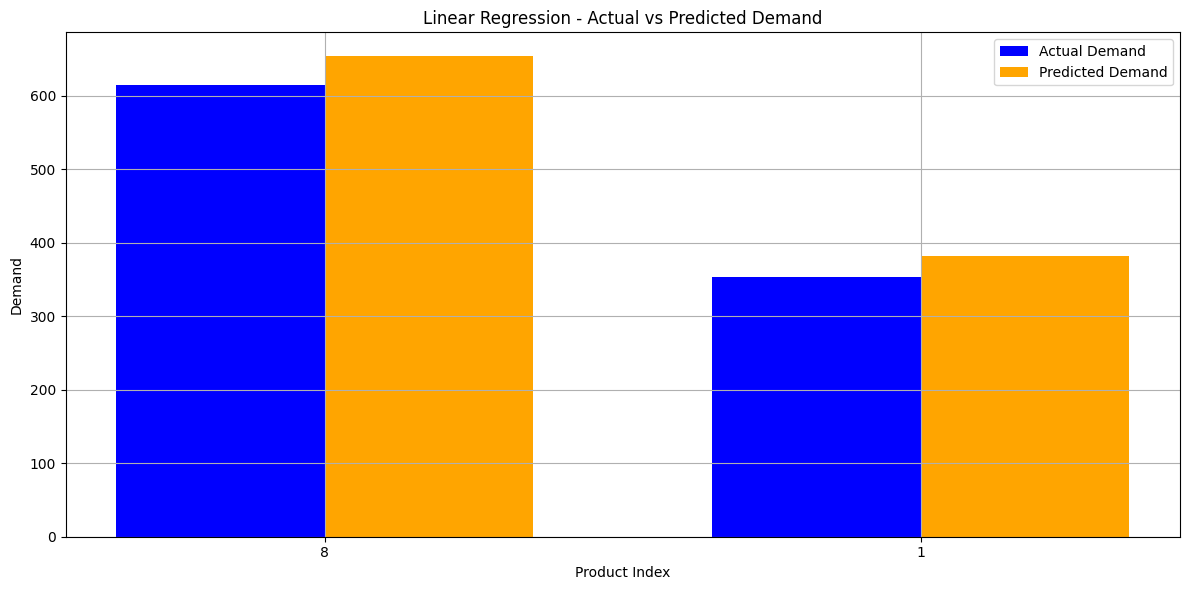

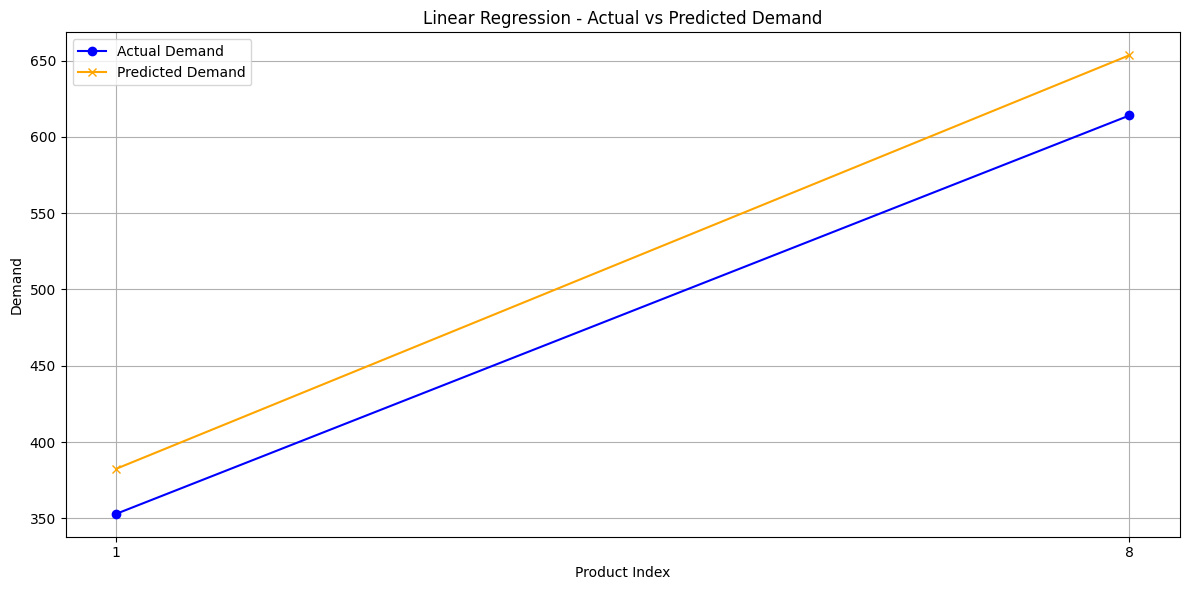

In [195]:
best_model_name = 'Linear Regression'
best_model = models[best_model_name]
y_pred_best = best_model.predict(x_test)

# Create a DataFrame for easier plotting
comparison_df = pd.DataFrame({
    'Product Index': x_test['productIndex'],
    'Actual Demand': y_test,
    'Predicted Demand': y_pred_best
})

# Bar Chart
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(comparison_df))

# Plot actual demand
plt.bar(index, comparison_df['Actual Demand'], bar_width, label='Actual Demand', color='blue')
# Plot predicted demand
plt.bar(index + bar_width, comparison_df['Predicted Demand'], bar_width, label='Predicted Demand', color='orange')

plt.xlabel('Product Index')
plt.ylabel('Demand')
plt.title(f'{best_model_name} - Actual vs Predicted Demand')
plt.xticks(index + bar_width / 2, comparison_df['Product Index'])
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Line Graph
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['Product Index'], comparison_df['Actual Demand'], marker='o', label='Actual Demand', color='blue')
plt.plot(comparison_df['Product Index'], comparison_df['Predicted Demand'], marker='x', label='Predicted Demand', color='orange')

plt.xlabel('Product Index')
plt.ylabel('Demand')
plt.title(f'{best_model_name} - Actual vs Predicted Demand')
plt.xticks(comparison_df['Product Index'])
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()